In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.patches as mpatches
from scipy.stats import ttest_ind, ttest_1samp, ttest_rel
import matplotlib as mpl

In [53]:
# mpl.rcParams['font.family'] = 'Avenir'
plt.rc('font', family='Helvetica')
plt.rcParams['font.size'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sns.set_palette("Dark2")

In [3]:
def deep_learning_cv_score(df):
    scores_cv_long = []
    for i in range(5):
        scores_multi_protein_cv_c = df[
            df['run'] == f'cv_{i}'].reset_index(drop=True)

        max_epoch = scores_multi_protein_cv_c.groupby(
            ['epoch']).median()['val_score'].reset_index()
        max_epoch = np.squeeze(max_epoch[max_epoch['val_score'] ==
                                         max_epoch['val_score'].max()]['epoch'])
        scores_cv_long.append(df[
            (df['run'] == f'cv_{i}')
            & (df['epoch'] == max_epoch)].reset_index(drop=True))
    scores_cv_long = pd.concat(scores_cv_long).drop(['epoch', 'mae'], axis=1)
    scores_cv_long['model'] = 'DL'
    return scores_cv_long

# ln_IC50

## test set

### model comparison

In [4]:
test_df_protein_list = []
col = ['drug_id', 'test_corr']

scores_en_protein = pd.read_csv("../work_dirs/protein/ElasticNet/scores_202006061215_ruv_min_300.csv")[col]
scores_en_protein['model'] = 'ENet'
scores_en_protein['data'] = 'protein'

scores_rf_protein = pd.read_csv(
    "../work_dirs/protein/RandomForest/scores_202006051013_ruv_min_300.csv")[col]
scores_rf_protein['model'] = 'RF'
scores_rf_protein['data'] = 'protein'
tmp_df = pd.concat([scores_en_protein, scores_rf_protein])
test_df_protein_list.append(tmp_df)

scores_multi_protein = pd.read_csv(
    "../work_dirs/protein/MultiDrug/scores_202006060123_resx_ruv_zero_300.csv"
)
scores_multi_protein_test = scores_multi_protein[
    scores_multi_protein['run'] == 'test'].reset_index(drop=True).rename(
        columns={'corr': 'test_corr'})
tmp_df = scores_multi_protein_test[scores_multi_protein_test['epoch']
                                        == 70][col].reset_index(drop=True)
tmp_df['model'] = 'DL'
tmp_df['data'] = 'protein'
test_df_protein_list.append(tmp_df)

test_corr_df_protein = pd.concat(test_df_protein_list)
test_corr_df_protein['key'] = test_corr_df_protein.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)

In [5]:
test_df_rna_list = []
col = ['drug_id', 'test_corr']

scores_en_rna = pd.read_csv("../work_dirs/rna/ElasticNet/scores_202006081309_rna_300.csv")[col]
scores_en_rna['model'] = 'ENet'
scores_en_rna['data'] = 'RNA'

scores_rf_rna = pd.read_csv(
    "../work_dirs/rna/RandomForest/scores_202006051532_rna_300.csv")[col]
scores_rf_rna['model'] = 'RF'
scores_rf_rna['data'] = 'RNA'
tmp_df = pd.concat([scores_en_rna, scores_rf_rna])
test_df_rna_list.append(tmp_df)

scores_multi_rna = pd.read_csv(
    "../work_dirs/rna/MultiDrug/scores_202006072037_res.csv"
)
scores_multi_rna_test = scores_multi_rna[
    scores_multi_rna['run'] == 'test'].reset_index(drop=True).rename(
        columns={'corr': 'test_corr'})
tmp_df = scores_multi_rna_test[scores_multi_rna_test['epoch']
                                        == 210][col].reset_index(drop=True)
tmp_df['model'] = 'DL'
tmp_df['data'] = 'RNA'
test_df_rna_list.append(tmp_df)

test_corr_df_rna = pd.concat(test_df_rna_list)
test_corr_df_rna['key'] = test_corr_df_rna.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)

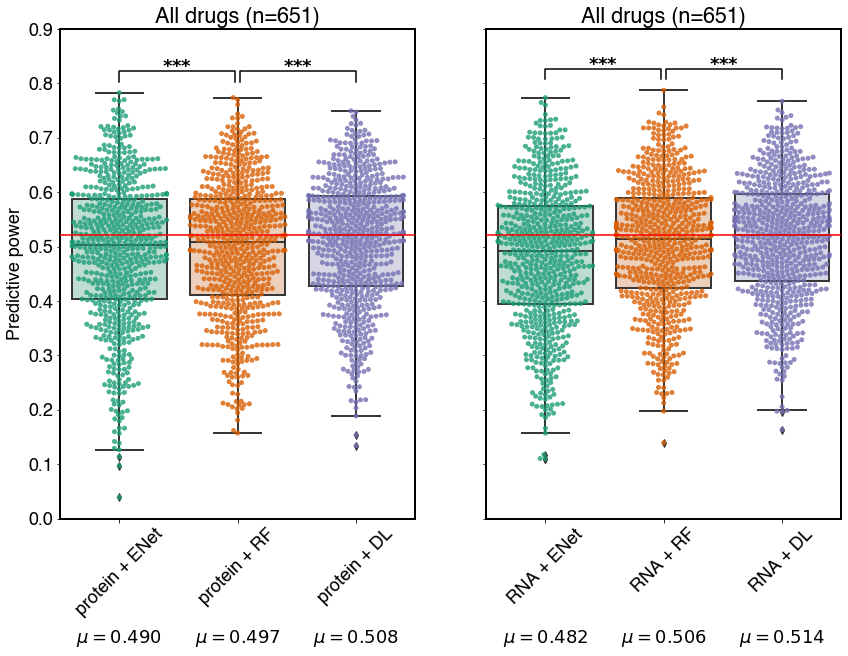

In [115]:
fig, ax = plt.subplots(1, 2, figsize=(14, 10), sharey=True)
ga = sns.boxplot('key',
                 'test_corr',
                 data=test_corr_df_protein,
                 orient='v',
                 linewidth=2,
                 ax=ax[0])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

sns.swarmplot('key',
              'test_corr',
              data=test_corr_df_protein,
              orient='vh',
              alpha=.8,
              ax=ax[0])

x1, x2 = 0, 0.98  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_df_protein['test_corr'].max() + 0.02, 0.02, 'k'
ax[0].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[0].text((x1 + x2) * .5,
           y + w + 0.01,
           r"$\bf{*}\bf{*}\bf{*}$",
           ha='center',
           va='center',
           color=col)
x1, x2 = 1.02, 2  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_df_protein['test_corr'].max() + 0.02, 0.02, 'k'
ax[0].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[0].text((x1 + x2) * .5,
           y + w + 0.01,
           r"$\bf{*}\bf{*}\bf{*}$",
           ha='center',
           va='center',
           color=col)
y = test_corr_df_protein[test_corr_df_protein['key'] ==
                         'protein + DL']['test_corr'].median()
ax[0].plot((-0.5, 2.5), [y, y], color='red', zorder=10)
ax[0].text(
    0,
    -0.22,
    f"$\mu={test_corr_df_protein[test_corr_df_protein['key']=='protein + ENet']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
ax[0].text(
    1,
    -0.22,
    f"$\mu={test_corr_df_protein[test_corr_df_protein['key']=='protein + RF']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
ax[0].text(
    2,
    -0.22,
    f"$\mu={test_corr_df_protein[test_corr_df_protein['key']=='protein + DL']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')

# RNA
ga = sns.boxplot('key',
                 'test_corr',
                 data=test_corr_df_rna,
                 orient='v',
                 linewidth=2,
                 ax=ax[1])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

sns.swarmplot('key',
              'test_corr',
              data=test_corr_df_rna,
              orient='vh',
              alpha=.8,
              ax=ax[1])

x1, x2 = 0, 0.98  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_df_rna['test_corr'].max() + 0.02, 0.02, 'k'
ax[1].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[1].text((x1 + x2) * .5,
           y + w + 0.01,
           r"$\bf{*}\bf{*}\bf{*}$",
           ha='center',
           va='center',
           color=col)
x1, x2 = 1.02, 2  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_df_rna['test_corr'].max() + 0.02, 0.02, 'k'
ax[1].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[1].text((x1 + x2) * .5,
           y + w + 0.01,
           r"$\bf{*}\bf{*}\bf{*}$",
           ha='center',
           va='center',
           color=col)
y = test_corr_df_rna[test_corr_df_rna['key'] ==
                     'RNA + DL']['test_corr'].median()
ax[1].plot((-0.5, 2.5), [y, y], color='red', zorder=10)
ax[1].text(
    0,
    -0.22,
    f"$\mu={test_corr_df_rna[test_corr_df_rna['key']=='RNA + ENet']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
ax[1].text(
    1,
    -0.22,
    f"$\mu={test_corr_df_rna[test_corr_df_rna['key']=='RNA + RF']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
ax[1].text(
    2,
    -0.22,
    f"$\mu={test_corr_df_rna[test_corr_df_rna['key']=='RNA + DL']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')

ax[0].set_ylabel('Predictive power')
ax[0].set_xlabel('')
ax[0].set_title('All drugs (n=651)')
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('All drugs (n=651)')
plt.ylim(0, .9)
fig.autofmt_xdate(rotation=45, ha='center')
plt.savefig("../plots/Fig4C.pdf", dpi=500)

In [7]:
ttest_rel(test_corr_df_rna[test_corr_df_rna['key']=='RNA + ENet']['test_corr'].values,
          test_corr_df_rna[test_corr_df_rna['key']=='RNA + RF']['test_corr'].values)

Ttest_relResult(statistic=-13.089751037928352, pvalue=6.452946783517595e-35)

In [8]:
ttest_rel(test_corr_df_protein[test_corr_df_protein['key']=='protein + ENet']['test_corr'].values,
          test_corr_df_protein[test_corr_df_protein['key']=='protein + RF']['test_corr'].values)

Ttest_relResult(statistic=-3.9980036284215257, pvalue=7.120526086443825e-05)

In [9]:
ttest_rel(test_corr_df_rna[test_corr_df_rna['key']=='RNA + RF']['test_corr'].values,
          test_corr_df_rna[test_corr_df_rna['key']=='RNA + DL']['test_corr'].values)

Ttest_relResult(statistic=-4.603014660235213, pvalue=5.009224539650335e-06)

In [10]:
ttest_rel(test_corr_df_protein[test_corr_df_protein['key']=='protein + RF']['test_corr'].values,
          test_corr_df_protein[test_corr_df_protein['key']=='protein + DL']['test_corr'].values)

Ttest_relResult(statistic=-5.911006859041587, pvalue=5.490797543997486e-09)

### data comparison

In [11]:
col = ['drug_id', 'test_corr']

In [12]:
test_corr_df_en = pd.concat([scores_en_protein, scores_en_rna])

test_corr_df_en['key'] = test_corr_df_en.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)

In [13]:
test_corr_df_rf = pd.concat([scores_rf_protein, scores_rf_rna])

test_corr_df_rf['key'] = test_corr_df_rf.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)

In [14]:
protein_df = scores_multi_protein_test[scores_multi_protein_test['epoch']
                                        == 70][col].reset_index(drop=True)
protein_df['model'] = 'DL'
protein_df['data'] = 'protein'

rna_df = scores_multi_rna_test[scores_multi_rna_test['epoch']
                                        == 210][col].reset_index(drop=True)
rna_df['model'] = 'DL'
rna_df['data'] = 'RNA'
test_corr_df_dl = pd.concat([protein_df, rna_df])

test_corr_df_dl['key'] = test_corr_df_dl.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)

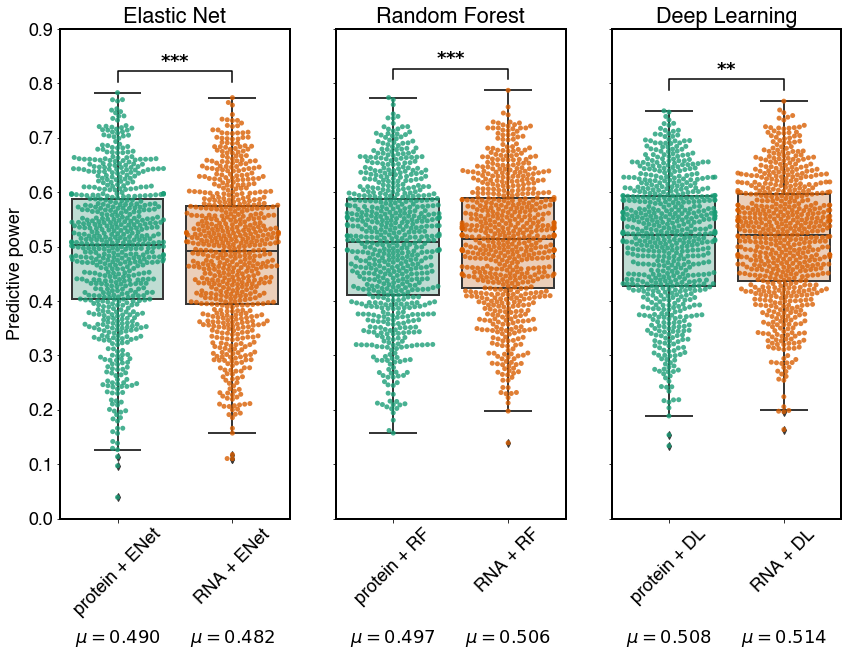

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(14, 10), sharey=True)
# EN
ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_df_en,
            orient='v',
            linewidth=2,
            ax=ax[0])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_df_en,
              orient='vh',
              alpha=.8,
              ax=ax[0])

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_df_en['test_corr'].max() + 0.02, 0.02, 'k'
ax[0].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[0].text((x1 + x2) * .5,
           y + w + 0.02,
           r"$\bf{*}\bf{*}\bf{*}$",
           ha='center',
           va='center',
           color=col)
ax[0].text(
    0,
    -0.22,
    f"$\mu={test_corr_df_en[test_corr_df_en['key']=='protein + ENet']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
ax[0].text(
    1,
    -0.22,
    f"$\mu={test_corr_df_en[test_corr_df_en['key']=='RNA + ENet']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
# RF
ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_df_rf,
            orient='v',
            linewidth=2,
            ax=ax[1])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_df_rf,
              orient='vh',
              alpha=.8,
              ax=ax[1])

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_df_rf['test_corr'].max() + 0.02, 0.02, 'k'
ax[1].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[1].text((x1 + x2) * .5,
           y + w + 0.02,
           r"$\bf{*}\bf{*}\bf{*}$",
           ha='center',
           va='center',
           color=col)
ax[1].text(
    0,
    -0.22,
    f"$\mu={test_corr_df_rf[test_corr_df_rf['key']=='protein + RF']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
ax[1].text(
    1,
    -0.22,
    f"$\mu={test_corr_df_rf[test_corr_df_rf['key']=='RNA + RF']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')

# DL
ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_df_dl,
            orient='v',
            linewidth=2,
            ax=ax[2])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_df_dl,
              orient='vh',
              alpha=.8,
              ax=ax[2])

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_df_dl['test_corr'].max() + 0.02, 0.02, 'k'
ax[2].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[2].text((x1 + x2) * .5,
           y + w + 0.02,
           r"$\bf{*}\bf{*}$",
           ha='center',
           va='center',
           color=col)
ax[2].text(
    0,
    -0.22,
    f"$\mu={test_corr_df_dl[test_corr_df_dl['key']=='protein + DL']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')
ax[2].text(
    1,
    -0.22,
    f"$\mu={test_corr_df_dl[test_corr_df_dl['key']=='RNA + DL']['test_corr'].mean():.3f}$",
    ha='center',
    va='center')

ax[0].set_ylabel('Predictive power')
ax[0].set_xlabel('')
ax[0].set_title('Elastic Net')
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('Random Forest')
ax[2].set_ylabel('')
ax[2].set_xlabel('')
ax[2].set_title('Deep Learning')
plt.ylim(0, .9)
fig.autofmt_xdate(rotation=45, ha='center')
plt.savefig("../plots/Fig4S-B.pdf", dpi=500)

In [16]:
ttest_rel(test_corr_df_en[test_corr_df_en['key']=='protein + ENet']['test_corr'].values,
          test_corr_df_en[test_corr_df_en['key']=='RNA + ENet']['test_corr'].values)

Ttest_relResult(statistic=3.388689781659346, pvalue=0.0007447035366478557)

In [17]:
ttest_rel(test_corr_df_rf[test_corr_df_rf['key']=='protein + RF']['test_corr'].values,
          test_corr_df_rf[test_corr_df_rf['key']=='RNA + RF']['test_corr'].values)

Ttest_relResult(statistic=-4.475828098882551, pvalue=8.987445549072406e-06)

In [18]:
ttest_rel(test_corr_df_dl[test_corr_df_dl['key']=='protein + DL']['test_corr'].values,
          test_corr_df_dl[test_corr_df_dl['key']=='RNA + DL']['test_corr'].values)

Ttest_relResult(statistic=-2.947570393457164, pvalue=0.0033176441053439777)

### protein RNA consistency

#### ENet

In [48]:
test_corr_df_en_scatter = pd.pivot(test_corr_df_en, index='drug_id', columns='key', values='test_corr')

In [49]:
test_corr_df_en_scatter['delta'] = test_corr_df_en_scatter[
    'protein + ENet'] - test_corr_df_en_scatter['RNA + ENet']
test_corr_df_en_scatter.sort_values(by='delta', ascending=False).head()

key,RNA + ENet,protein + ENet,delta
drug_id,,,
1029,0.209053,0.543336,0.334283
1945,0.110463,0.365488,0.255025
147,0.191199,0.389392,0.198193
1518,0.157162,0.350737,0.193575
2075,0.221225,0.410655,0.189430


Text(-30, 40, 'Motesanib:RTK signaling')

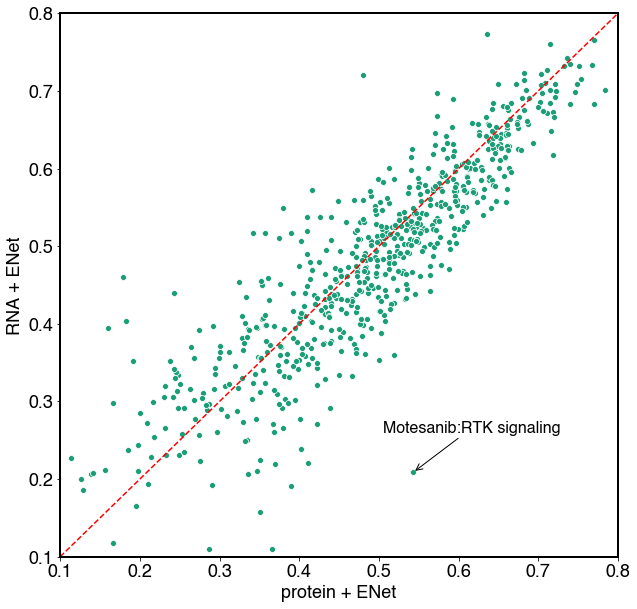

In [52]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x='protein + ENet', y='RNA + ENet', data=test_corr_df_en_scatter)
plt.xlim(0.1,0.8)
plt.ylim(0.1,0.8)
plt.plot((0.1,0.8), (0.1,0.8), ls="--", c='red')
ax.annotate('Motesanib:RTK signaling',
            xy=(0.543336, 0.209053), xycoords='data',
            xytext=(-30, 40), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), fontsize=16)

In [51]:
pearsonr(test_corr_df_en_scatter['protein + ENet'], test_corr_df_en_scatter['RNA + ENet'])

(0.8829757742400031, 2.466712137461126e-215)

#### RF

In [19]:
test_corr_df_rf_scatter = pd.pivot(test_corr_df_rf, index='drug_id', columns='key', values='test_corr')

In [27]:
test_corr_df_rf_scatter['delta'] = test_corr_df_rf_scatter[
    'protein + RF'] - test_corr_df_rf_scatter['RNA + RF']
test_corr_df_rf_scatter.sort_values(by='delta', ascending=False).head()

key,RNA + RF,protein + RF,delta
drug_id,,,
1029,0.270056,0.551617,0.281561
1149,0.293766,0.476808,0.183042
2255,0.326783,0.467282,0.140499
59,0.367091,0.501940,0.134849
147,0.254259,0.373365,0.119107


Text(-30, 40, 'Motesanib:RTK signaling')

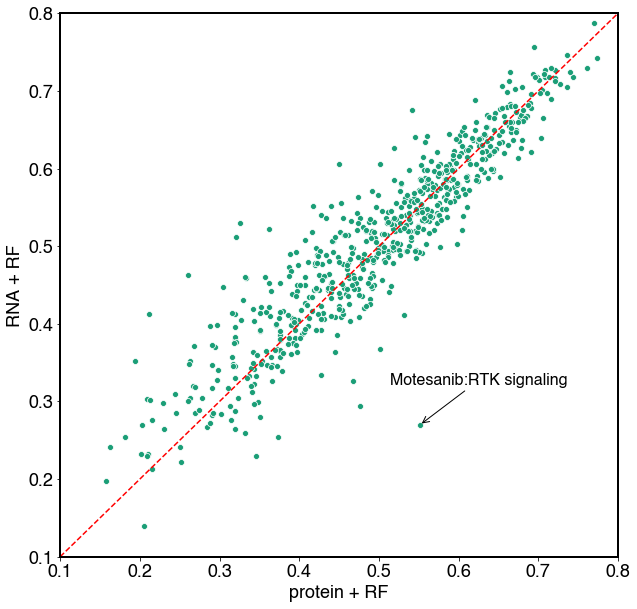

In [45]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x='protein + RF', y='RNA + RF', data=test_corr_df_rf_scatter)
plt.xlim(0.1,0.8)
plt.ylim(0.1,0.8)
plt.plot((0.1,0.8), (0.1,0.8), ls="--", c='red')
ax.annotate('Motesanib:RTK signaling',
            xy=(0.551617, 0.270056), xycoords='data',
            xytext=(-30, 40), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), fontsize=16)

In [26]:
pearsonr(test_corr_df_rf_scatter['protein + RF'], test_corr_df_rf_scatter['RNA + RF'])

(0.9243568588305225, 8.731702775381443e-274)

#### DL

In [28]:
test_corr_df_dl_scatter = pd.pivot(test_corr_df_dl, index='drug_id', columns='key', values='test_corr')

In [32]:
test_corr_df_dl_scatter['delta'] = test_corr_df_dl_scatter[
    'protein + DL'] - test_corr_df_dl_scatter['RNA + DL']
test_corr_df_dl_scatter.sort_values(by='delta', ascending=False).head()

key,RNA + DL,protein + DL,delta
drug_id,,,
1029,0.197453,0.620234,0.422780
1149,0.286321,0.515766,0.229444
1018,0.409210,0.591887,0.182677
2255,0.380139,0.556484,0.176346
1020,0.509885,0.684129,0.174243


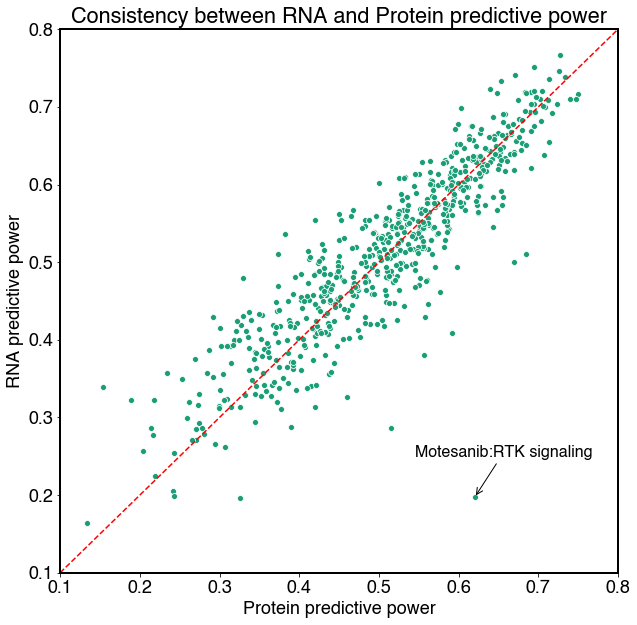

In [116]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x='protein + DL', y='RNA + DL', data=test_corr_df_dl_scatter)
plt.xlim(0.1,0.8)
plt.ylim(0.1,0.8)
plt.plot((0.1,0.8), (0.1,0.8), ls="--", c='red')
ax.annotate('Motesanib:RTK signaling',
            xy=(0.620234, 0.197453), xycoords='data',
            xytext=(-60, 40), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.title("Consistency between RNA and Protein predictive power")
plt.ylabel("RNA predictive power")
plt.xlabel("Protein predictive power")

plt.savefig("../plots/Fig4D.pdf", dpi=500)

In [159]:
pearsonr(test_corr_df_dl_scatter['protein + DL'], test_corr_df_dl_scatter['RNA + DL'])

(0.8987136973583052, 1.5965432693412805e-234)

## CV

In [61]:
col = ['drug_id', 'cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr']
# TODO: change to RNA!!!
scores_en_rna_cv = pd.read_csv(
    "../work_dirs/rna/ElasticNet/scores_202006081309_rna_300.csv")[col]
scores_rf_rna_cv = pd.read_csv(
    "../work_dirs/rna/RandomForest/scores_202006051532_rna_300.csv")[col]
scores_multi_rna_cv = pd.read_csv(
    "../work_dirs/rna/MultiDrug/scores_202006072037_res.csv")

scores_multi_rna_cv = scores_multi_rna_cv[
    scores_multi_rna_cv['run'] != 'test'].reset_index(drop=True).rename(
        columns={'corr': 'val_score'})

In [62]:
col = ['drug_id', 'cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr']
scores_en_protein_cv = pd.read_csv(
    "../work_dirs/protein/ElasticNet/scores_202006061215_ruv_min_300.csv")[col]
scores_rf_protein_cv = pd.read_csv(
    "../work_dirs/protein/RandomForest/scores_202006051013_ruv_min_300.csv"
)[col]
scores_multi_protein_cv = pd.read_csv(
    "../work_dirs/protein/MultiDrug/scores_202006060123_resx_ruv_zero_300.csv")

scores_multi_protein_cv = scores_multi_protein_cv[
    scores_multi_protein_cv['run'] != 'test'].reset_index(drop=True).rename(
        columns={'corr': 'val_score'})

In [63]:
scores_en_protein_cv_long = pd.melt(
    scores_en_protein_cv,
    id_vars='drug_id',
    value_vars=['cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr'],
    var_name='run',
    value_name='val_score')
scores_en_protein_cv_long['model'] = 'ENet'
scores_en_protein_cv_long['data'] = 'protein'


scores_rf_protein_cv_long = pd.melt(
    scores_rf_protein_cv,
    id_vars='drug_id',
    value_vars=['cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr'],
    var_name='run',
    value_name='val_score')
scores_rf_protein_cv_long['model'] = 'RF'
scores_rf_protein_cv_long['data'] = 'protein'

scores_dl_protein_cv_long = deep_learning_cv_score(scores_multi_protein_cv)
scores_dl_protein_cv_long['data'] = 'protein'

In [64]:
scores_en_rna_cv_long = pd.melt(
    scores_en_rna_cv,
    id_vars='drug_id',
    value_vars=['cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr'],
    var_name='run',
    value_name='val_score')
scores_en_rna_cv_long['model'] = 'ENet'
scores_en_rna_cv_long['data'] = 'RNA'

scores_rf_rna_cv_long = pd.melt(
    scores_rf_rna_cv,
    id_vars='drug_id',
    value_vars=['cv0_corr', 'cv1_corr', 'cv2_corr', 'cv3_corr', 'cv4_corr'],
    var_name='run',
    value_name='val_score')
scores_rf_rna_cv_long['model'] = 'RF'
scores_rf_rna_cv_long['data'] = 'RNA'
scores_dl_rna_cv_long = deep_learning_cv_score(scores_multi_rna_cv)
scores_dl_rna_cv_long['data'] = 'RNA'

### performance bar plot

In [21]:
rna_cv_bar = pd.concat([scores_en_rna_cv_long, scores_rf_rna_cv_long, scores_dl_rna_cv_long])
rna_cv_bar['key'] = rna_cv_bar.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)

In [22]:
protein_cv_bar = pd.concat([scores_en_protein_cv_long, scores_rf_protein_cv_long, scores_dl_protein_cv_long])
protein_cv_bar['key'] = protein_cv_bar.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)

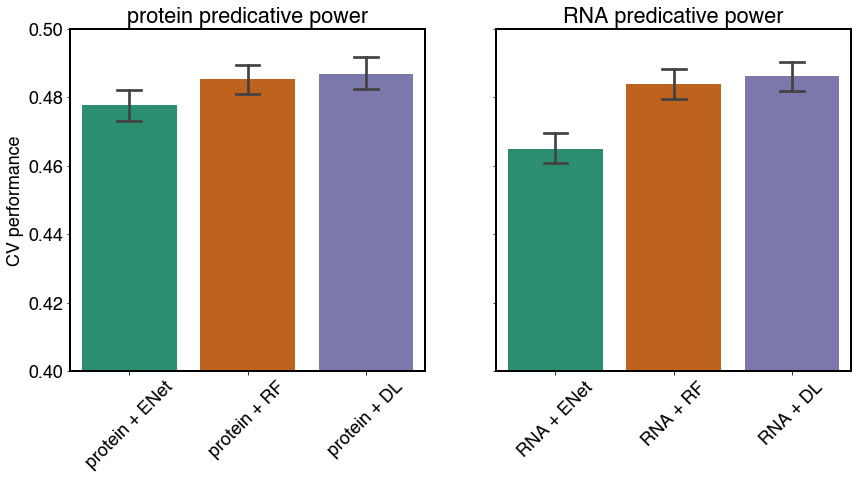

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
sns.barplot(x='key', y='val_score', data=protein_cv_bar, capsize=.2, ax=ax[0])
sns.barplot(x='key', y='val_score', data=rna_cv_bar, capsize=.2, ax=ax[1])
ax[0].set_ylabel('CV performance')
ax[0].set_xlabel('')
ax[0].set_title('protein predicative power')
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('RNA predicative power')
plt.ylim(0.4,0.5)
fig.autofmt_xdate(rotation=45, ha='center')

In [24]:
en_cv_bar = pd.concat([scores_en_protein_cv_long, scores_en_rna_cv_long])
rf_cv_bar = pd.concat([scores_rf_protein_cv_long, scores_rf_rna_cv_long])
dl_cv_bar = pd.concat([scores_dl_protein_cv_long, scores_dl_rna_cv_long])
en_cv_bar['key'] = en_cv_bar.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)
rf_cv_bar['key'] = rf_cv_bar.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)
dl_cv_bar['key'] = dl_cv_bar.apply(lambda row:f"{row['data']} + {row['model']}", axis=1)

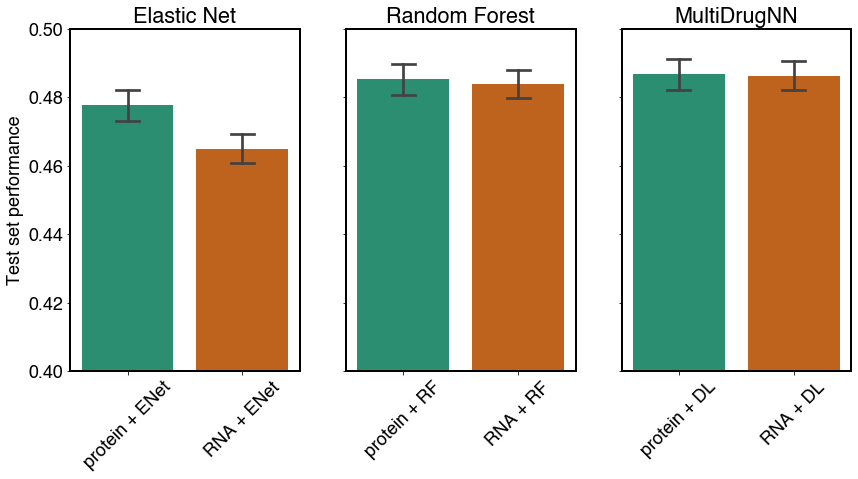

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(14, 7), sharey=True)
sns.barplot(x='key', y='val_score', data=en_cv_bar, capsize=.2, ax=ax[0])
sns.barplot(x='key', y='val_score', data=rf_cv_bar, capsize=.2, ax=ax[1])
sns.barplot(x='key', y='val_score', data=dl_cv_bar, capsize=.2, ax=ax[2])

ax[0].set_ylabel('Test set performance')
ax[0].set_xlabel('')
ax[0].set_title('Elastic Net')
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('Random Forest')
ax[2].set_ylabel('')
ax[2].set_xlabel('')
ax[2].set_title('MultiDrugNN')
plt.ylim(0.4,0.5)
fig.autofmt_xdate(rotation=45, ha='center')

### stability

In [110]:
scores_en_rna_cv_long_stderr = scores_en_rna_cv_long.groupby(
    ['drug_id', 'model',
     'data'])['val_score'].std().reset_index(name='std_erorr')
scores_rf_rna_cv_long_stderr = scores_rf_rna_cv_long.groupby(
    ['drug_id', 'model',
     'data'])['val_score'].std().reset_index(name='std_erorr')
scores_dl_rna_cv_long_stderr = scores_dl_rna_cv_long.groupby(
    ['drug_id', 'model',
     'data'])['val_score'].std().reset_index(name='std_erorr')

In [111]:
scores_en_protein_cv_long_stderr = scores_en_protein_cv_long.groupby(
    ['drug_id', 'model',
     'data'])['val_score'].std().reset_index(name='std_erorr')
scores_rf_protein_cv_long_stderr = scores_rf_protein_cv_long.groupby(
    ['drug_id', 'model',
     'data'])['val_score'].std().reset_index(name='std_erorr')
scores_dl_protein_cv_long_stderr = scores_dl_protein_cv_long.groupby(
    ['drug_id', 'model',
     'data'])['val_score'].std().reset_index(name='std_erorr')

In [112]:
rna_cv_bar_stderr = pd.concat([
    scores_en_rna_cv_long_stderr, scores_rf_rna_cv_long_stderr,
    scores_dl_rna_cv_long_stderr
])
rna_cv_bar_stderr['key'] = rna_cv_bar_stderr.apply(
    lambda row: f"{row['data']} + {row['model']}", axis=1)

protein_cv_bar_stderr = pd.concat([
    scores_en_protein_cv_long_stderr, scores_rf_protein_cv_long_stderr,
    scores_dl_protein_cv_long_stderr
])
protein_cv_bar_stderr['key'] = protein_cv_bar_stderr.apply(
    lambda row: f"{row['data']} + {row['model']}", axis=1)

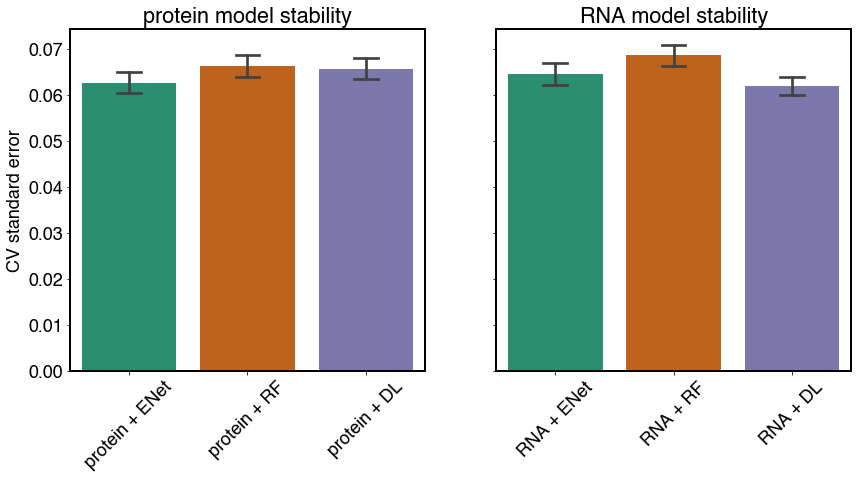

In [114]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
sns.barplot(x='key', y='std_erorr', data=protein_cv_bar_stderr, capsize=.2, ax=ax[0])
sns.barplot(x='key', y='std_erorr', data=rna_cv_bar_stderr, capsize=.2, ax=ax[1])
ax[0].set_ylabel('CV standard error')
ax[0].set_xlabel('')
ax[0].set_title('protein model stability')
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('RNA model stability')
fig.autofmt_xdate(rotation=45, ha='center')
plt.savefig("../plots/Fig4S-D.pdf")

## CV + Test consistency

### ENet

In [91]:
combined_en = pd.concat([
    test_corr_df_en.rename(columns={'test_corr': 'score'}),
    scores_en_protein_cv_long.rename(columns={'val_score': 'score'}),
    scores_en_rna_cv_long.rename(columns={'val_score': 'score'})
])
combined_corr_df_en_scatter = pd.pivot(combined_en.groupby(
    ['drug_id', 'data'])['score'].mean().reset_index(name='score'),
                                       index='drug_id',
                                       columns='data', values='score')

In [94]:
combined_corr_df_en_scatter['delta'] = combined_corr_df_en_scatter[
    'protein'] - combined_corr_df_en_scatter['RNA']
combined_corr_df_en_scatter.sort_values(by='delta', ascending=False).head()

data,RNA,protein,delta
drug_id,,,
1029,0.175817,0.547190,0.371373
1016,0.315191,0.520034,0.204844
2255,0.231102,0.427675,0.196572
1960,0.408529,0.597210,0.188681
1018,0.364965,0.544894,0.179929


Text(-30, 40, 'Motesanib:RTK signaling')

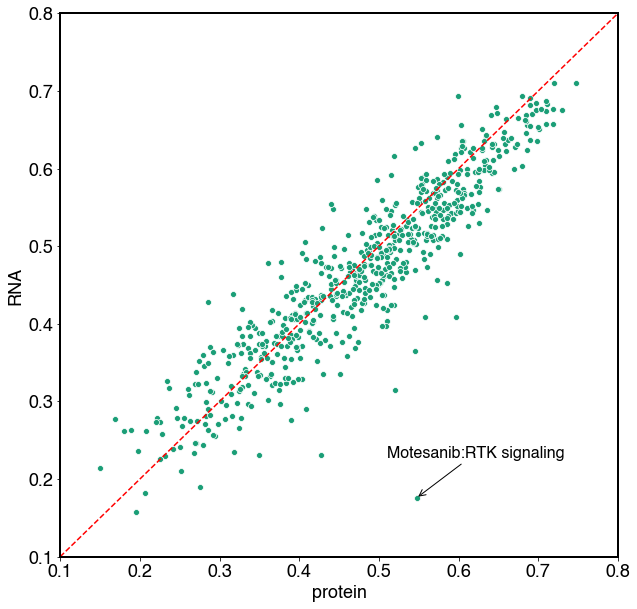

In [95]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x='protein', y='RNA', data=combined_corr_df_en_scatter)
plt.xlim(0.1,0.8)
plt.ylim(0.1,0.8)
plt.plot((0.1,0.8), (0.1,0.8), ls="--", c='red')
ax.annotate('Motesanib:RTK signaling',
            xy=(0.547190, 0.175817), xycoords='data',
            xytext=(-30, 40), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), fontsize=16)

### RF

In [98]:
combined_rf = pd.concat([
    test_corr_df_rf.rename(columns={'test_corr': 'score'}),
    scores_rf_protein_cv_long.rename(columns={'val_score': 'score'}),
    scores_rf_rna_cv_long.rename(columns={'val_score': 'score'})
])
combined_corr_df_rf_scatter = pd.pivot(combined_rf.groupby(
    ['drug_id', 'data'])['score'].mean().reset_index(name='score'),
                                       index='drug_id',
                                       columns='data', values='score')

In [100]:
combined_corr_df_rf_scatter['delta'] = combined_corr_df_rf_scatter[
    'protein'] - combined_corr_df_rf_scatter['RNA']
combined_corr_df_rf_scatter.sort_values(by='delta', ascending=False).head()

data,RNA,protein,delta
drug_id,,,
1029,0.232796,0.542736,0.309940
2255,0.286031,0.443420,0.157389
1018,0.394889,0.541634,0.146745
1016,0.340698,0.477128,0.136429
1149,0.298444,0.425680,0.127235


Text(-30, 40, 'Motesanib:RTK signaling')

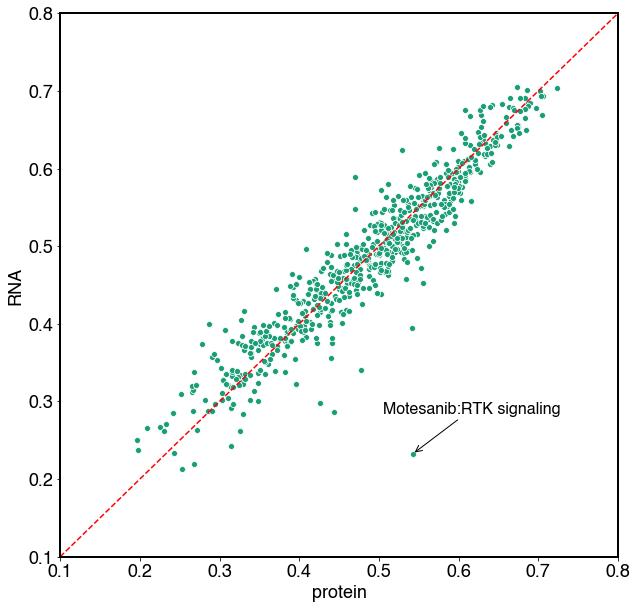

In [101]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x='protein', y='RNA', data=combined_corr_df_rf_scatter)
plt.xlim(0.1,0.8)
plt.ylim(0.1,0.8)
plt.plot((0.1,0.8), (0.1,0.8), ls="--", c='red')
ax.annotate('Motesanib:RTK signaling',
            xy=(0.542736, 0.232796), xycoords='data',
            xytext=(-30, 40), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), fontsize=16)

### DL

In [102]:
combined_dl = pd.concat([
    test_corr_df_dl.rename(columns={'test_corr': 'score'}),
    scores_dl_protein_cv_long.rename(columns={'val_score': 'score'}),
    scores_dl_rna_cv_long.rename(columns={'val_score': 'score'})
])
combined_corr_df_dl_scatter = pd.pivot(combined_dl.groupby(
    ['drug_id', 'data'])['score'].mean().reset_index(name='score'),
                                       index='drug_id',
                                       columns='data', values='score')

In [103]:
combined_corr_df_dl_scatter['delta'] = combined_corr_df_dl_scatter[
    'protein'] - combined_corr_df_dl_scatter['RNA']
combined_corr_df_dl_scatter.sort_values(by='delta', ascending=False).head()

data,RNA,protein,delta
drug_id,,,
1029,0.193069,0.621713,0.428644
1016,0.323235,0.547937,0.224702
1018,0.383363,0.603456,0.220093
1020,0.433297,0.613803,0.180506
1960,0.462883,0.609694,0.146811


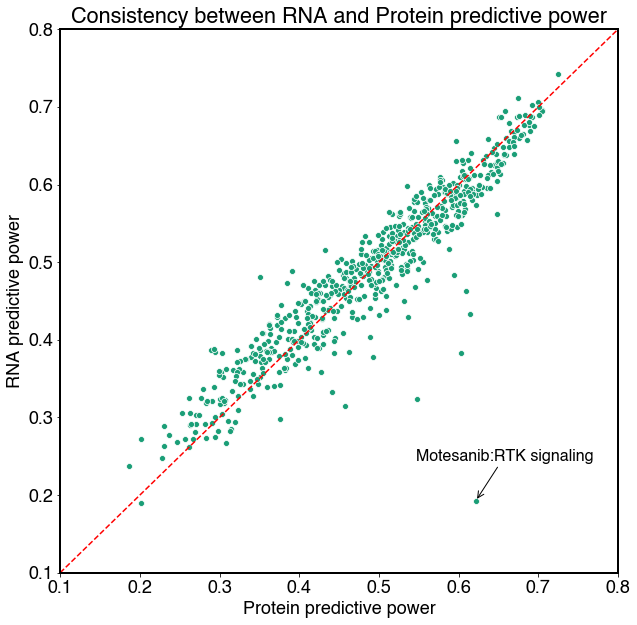

In [108]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x='protein', y='RNA', data=combined_corr_df_dl_scatter)
plt.xlim(0.1,0.8)
plt.ylim(0.1,0.8)
plt.plot((0.1,0.8), (0.1,0.8), ls="--", c='red')
ax.annotate('Motesanib:RTK signaling',
            xy=(0.621713, 0.193069), xycoords='data',
            xytext=(-60, 40), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"), fontsize=16)

plt.title("Consistency between RNA and Protein predictive power")
plt.ylabel("RNA predictive power")
plt.xlabel("Protein predictive power")

plt.savefig("../plots/Fig4C.pdf", dpi=500)

# growth rate

In [78]:
col = ['drug_id', 'test_corr']

## data comparison

### load data

In [87]:
scores_multi_rna = pd.read_csv(
    "../work_dirs/rna/MultiDrug/scores_202006072037_res.csv")
scores_multi_rna = scores_multi_rna[
    scores_multi_rna['run'] == 'test'].reset_index(drop=True).rename(
        columns={'corr': 'test_corr'})

scores_multi_rna_growth_corrected = pd.read_csv(
    "../work_dirs/rna/MultiDrug/scores_202006072223_res_growth_corrected.csv"
)
scores_multi_rna_growth_corrected = scores_multi_rna_growth_corrected[
    scores_multi_rna_growth_corrected['run'] == 'test'].reset_index(
        drop=True).rename(columns={'corr': 'test_corr'})

scores_multi_rna_pc1_corrected = pd.read_csv(
    "../work_dirs/rna/MultiDrug/scores_202006072224_res_pc1_corrected.csv"
)
scores_multi_rna_pc1_corrected = scores_multi_rna_pc1_corrected[
    scores_multi_rna_pc1_corrected['run'] == 'test'].reset_index(
        drop=True).rename(columns={'corr': 'test_corr'})

In [88]:
scores_multi_protein = pd.read_csv(
    "../work_dirs/protein/MultiDrug/scores_202006060123_resx_ruv_zero_300.csv")
scores_multi_protein = scores_multi_protein[
    scores_multi_protein['run'] == 'test'].reset_index(drop=True).rename(
        columns={'corr': 'test_corr'})

scores_multi_protein_growth_corrected = pd.read_csv(
    "../work_dirs/protein/MultiDrug/scores_202006061203_resx_ruv_zero_300_growth_corrected.csv"
)
scores_multi_protein_growth_corrected = scores_multi_protein_growth_corrected[
    scores_multi_protein_growth_corrected['run'] == 'test'].reset_index(
        drop=True).rename(columns={'corr': 'test_corr'})

scores_multi_protein_pc1_corrected = pd.read_csv(
    "../work_dirs/protein/MultiDrug/scores_202006061203_resx_ruv_zero_300_pc1_corrected.csv"
)
scores_multi_protein_pc1_corrected = scores_multi_protein_pc1_corrected[
    scores_multi_protein_pc1_corrected['run'] == 'test'].reset_index(
        drop=True).rename(columns={'corr': 'test_corr'})

In [89]:
rna_df = scores_multi_rna[scores_multi_rna['epoch'] ==
                                  210][col].reset_index(drop=True)
rna_df['model'] = 'DL'
rna_df['data'] = 'RNA + IC50'

rna_df_growth_corrected = scores_multi_rna_growth_corrected[
    scores_multi_rna_growth_corrected['epoch'] == 130][col].reset_index(
        drop=True)
rna_df_growth_corrected['model'] = 'DL'
rna_df_growth_corrected['data'] = 'RNA + IC50(no GR)'

rna_df_pc1_corrected = scores_multi_rna_pc1_corrected[
    scores_multi_rna_pc1_corrected['epoch'] == 70][col].reset_index(
        drop=True)
rna_df_pc1_corrected['model'] = 'DL'
rna_df_pc1_corrected['data'] = 'RNA + IC50(no PC1)'

test_corr_df_rna = pd.concat(
    [rna_df, rna_df_growth_corrected, rna_df_pc1_corrected])

test_corr_df_rna['key'] = test_corr_df_rna.apply(
    lambda row: f"{row['data']}", axis=1)

In [90]:
protein_df = scores_multi_protein[scores_multi_protein['epoch'] ==
                                  70][col].reset_index(drop=True)
protein_df['model'] = 'DL'
protein_df['data'] = 'protein + IC50'

protein_df_growth_corrected = scores_multi_protein_growth_corrected[
    scores_multi_protein_growth_corrected['epoch'] == 25][col].reset_index(
        drop=True)
protein_df_growth_corrected['model'] = 'DL'
protein_df_growth_corrected['data'] = 'protein + IC50(no GR)'

protein_df_pc1_corrected = scores_multi_protein_pc1_corrected[
    scores_multi_protein_pc1_corrected['epoch'] == 25][col].reset_index(
        drop=True)
protein_df_pc1_corrected['model'] = 'DL'
protein_df_pc1_corrected['data'] = 'protein + IC50(no PC1)'

test_corr_df_protein = pd.concat(
    [protein_df, protein_df_growth_corrected, protein_df_pc1_corrected])

test_corr_df_protein['key'] = test_corr_df_protein.apply(
    lambda row: f"{row['data']}", axis=1)

### plot

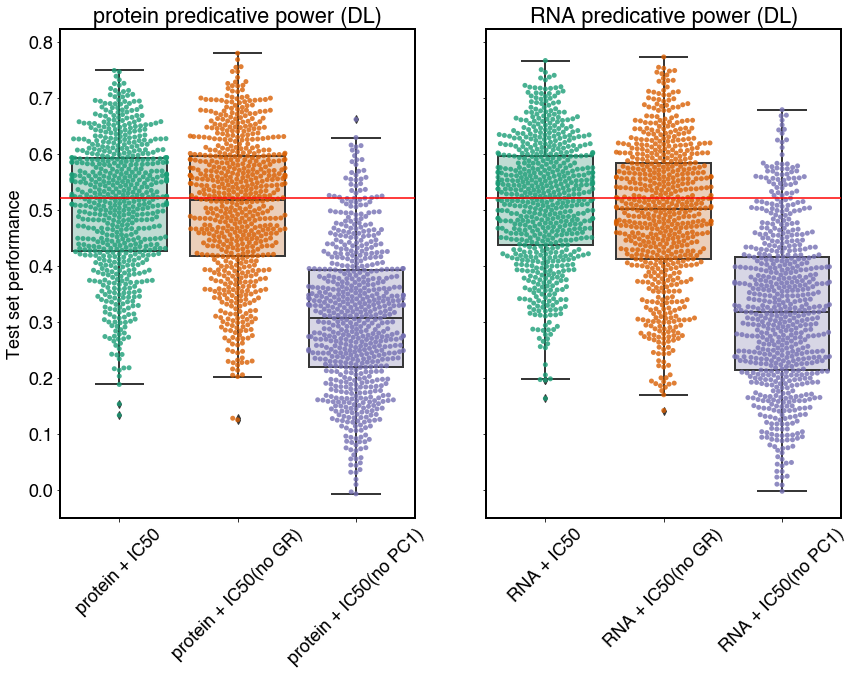

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(14, 10), sharey=True)
ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_df_protein,
            orient='v',
            linewidth=2,
            ax=ax[0])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_df_protein,
              orient='vh',
              alpha=.8,
              ax=ax[0])

x1, x2 = 1, 2  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y = test_corr_df_protein[
    test_corr_df_protein['key'] ==
    'protein + IC50']['test_corr'].median()
ax[0].plot((-0.5,2.5), [y, y], color='red', zorder=10)


ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_df_rna,
            orient='v',
            linewidth=2,
            ax=ax[1])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_df_rna,
              orient='vh',
              alpha=.8,
              ax=ax[1])


y = test_corr_df_rna[
    test_corr_df_rna['key'] ==
    'RNA + IC50']['test_corr'].median()
ax[1].plot((-0.5,2.5), [y, y], color='red', zorder=10)


ax[0].set_ylabel('Test set performance')
ax[0].set_xlabel('')
ax[0].set_title('protein predicative power (DL)')
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('RNA predicative power (DL)')
# plt.ylim(0, .9)
fig.autofmt_xdate(rotation=45, ha='center')

## model comparison

### load RF

In [93]:
scores_rf_rna = pd.read_csv(
    "../work_dirs/rna/RandomForest/scores_202006051532_rna_300.csv")[col]
scores_rf_rna['model'] = 'RF'
scores_rf_rna['data'] = 'RNA + IC50'

scores_rf_rna_growth_corrected = pd.read_csv(
    "../work_dirs/rna/RandomForest/scores_202006062032_rna_300_growth_corrected.csv")[col]
scores_rf_rna_growth_corrected['model'] = 'RF'
scores_rf_rna_growth_corrected['data'] = 'RNA + IC50(no GR)'

scores_rf_rna_pc1_corrected = pd.read_csv(
    "../work_dirs/rna/RandomForest/scores_202006062032_rna_300_pc1_corrected.csv")[col]
scores_rf_rna_pc1_corrected['model'] = 'RF'
scores_rf_rna_pc1_corrected['data'] = 'RNA + IC50(no PC1)'

In [94]:
scores_rf_protein = pd.read_csv(
    "../work_dirs/protein/RandomForest/scores_202006051013_ruv_min_300.csv")[col]
scores_rf_protein['model'] = 'RF'
scores_rf_protein['data'] = 'protein + IC50'

scores_rf_protein_growth_corrected = pd.read_csv(
    "../work_dirs/protein/RandomForest/scores_202006052029_ruv_min_300_growth_corrected.csv")[col]
scores_rf_protein_growth_corrected['model'] = 'RF'
scores_rf_protein_growth_corrected['data'] = 'protein + IC50(no GR)'

scores_rf_protein_pc1_corrected = pd.read_csv(
    "../work_dirs/protein/RandomForest/scores_202006061137_ruv_min_300_pc1_corrected.csv")[col]
scores_rf_protein_pc1_corrected['model'] = 'RF'
scores_rf_protein_pc1_corrected['data'] = 'protein + IC50(no PC1)'

In [95]:
scores_dl_rna = scores_multi_rna[scores_multi_rna['epoch'] ==
                                  210][col].reset_index(drop=True)
scores_dl_rna['model'] = 'DL'
scores_dl_rna['data'] = 'RNA + IC50'

scores_dl_rna_growth_corrected = scores_multi_rna_growth_corrected[
    scores_multi_rna_growth_corrected['epoch'] == 130][col].reset_index(
        drop=True)
scores_dl_rna_growth_corrected['model'] = 'DL'
scores_dl_rna_growth_corrected['data'] = 'RNA + IC50(no GR)'

scores_dl_rna_pc1_corrected = scores_multi_rna_pc1_corrected[
    scores_multi_rna_pc1_corrected['epoch'] == 70][col].reset_index(
        drop=True)
scores_dl_rna_pc1_corrected['model'] = 'DL'
scores_dl_rna_pc1_corrected['data'] = 'RNA + IC50(no PC1)'

In [97]:
scores_dl_protein = scores_multi_protein[scores_multi_protein['epoch'] ==
                                  70][col].reset_index(drop=True)
scores_dl_protein['model'] = 'DL'
scores_dl_protein['data'] = 'protein + IC50'

scores_dl_protein_growth_corrected = scores_multi_protein_growth_corrected[
    scores_multi_protein_growth_corrected['epoch'] == 25][col].reset_index(
        drop=True)
scores_dl_protein_growth_corrected['model'] = 'DL'
scores_dl_protein_growth_corrected['data'] = 'protein + IC50(no GR)'

scores_dl_protein_pc1_corrected = scores_multi_protein_pc1_corrected[
    scores_multi_protein_pc1_corrected['epoch'] == 25][col].reset_index(
        drop=True)
scores_dl_protein_pc1_corrected['model'] = 'DL'
scores_dl_protein_pc1_corrected['data'] = 'protein + IC50(no PC1)'

In [100]:
test_corr_rna_ori = pd.concat([scores_rf_rna, scores_dl_rna])
test_corr_rna_ori['key'] = test_corr_rna_ori.apply(
    lambda row: f"{row['data']} + {row['model']}", axis=1)

test_corr_rna_growth_corrected = pd.concat([scores_rf_rna_growth_corrected, scores_dl_rna_growth_corrected])
test_corr_rna_growth_corrected['key'] = test_corr_rna_growth_corrected.apply(
    lambda row: f"{row['data']} + {row['model']}", axis=1)

test_corr_rna_pc1_corrected = pd.concat([scores_rf_rna_pc1_corrected, scores_dl_rna_pc1_corrected])
test_corr_rna_pc1_corrected['key'] = test_corr_rna_pc1_corrected.apply(
    lambda row: f"{row['data']} + {row['model']}", axis=1)

In [111]:
test_corr_protein_ori = pd.concat([scores_rf_protein, scores_dl_protein])
test_corr_protein_ori['key'] = test_corr_protein_ori.apply(
    lambda row: f"{row['data']} + {row['model']}", axis=1)

test_corr_protein_growth_corrected = pd.concat([scores_rf_protein_growth_corrected, scores_dl_protein_growth_corrected])
test_corr_protein_growth_corrected['key'] = test_corr_protein_growth_corrected.apply(
    lambda row: f"{row['data']} + {row['model']}", axis=1)

test_corr_protein_pc1_corrected = pd.concat([scores_rf_protein_pc1_corrected, scores_dl_protein_pc1_corrected])
test_corr_protein_pc1_corrected['key'] = test_corr_protein_pc1_corrected.apply(
    lambda row: f"{row['data']} + {row['model']}", axis=1)

### plot

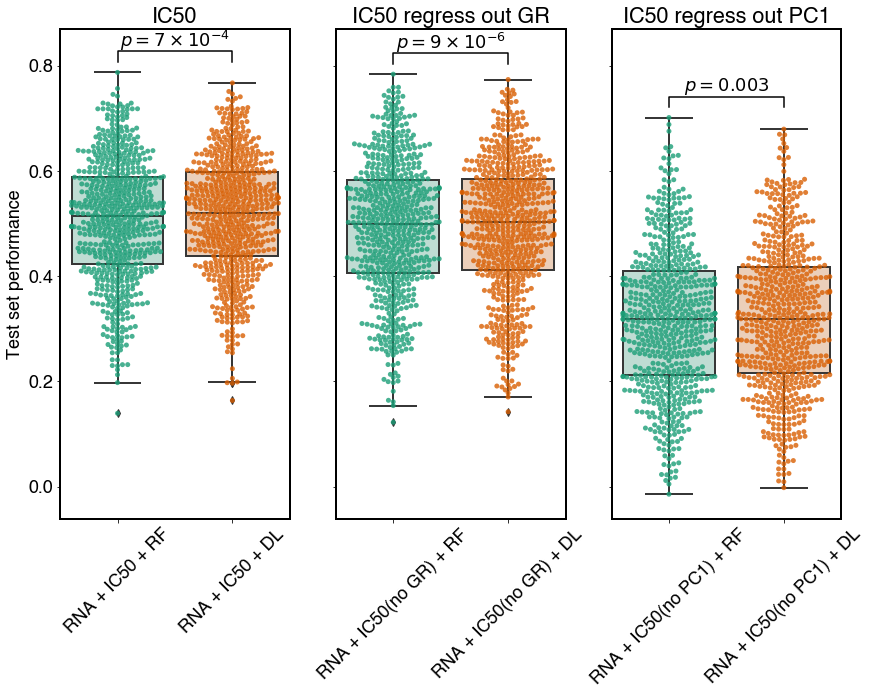

In [104]:
fig, ax = plt.subplots(1, 3, figsize=(14, 10), sharey=True)
ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_rna_ori,
            orient='v',
            linewidth=2,
            ax=ax[0])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_rna_ori,
              orient='vh',
              alpha=.8,
              ax=ax[0])

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_rna_ori['test_corr'].max() + 0.02, 0.02, 'k'
ax[0].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[0].text((x1 + x2) * .5,
           y + w + 0.02,
           r"$p=5\times10^{-6}$",
           ha='center',
           va='center',
           color=col)

ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_rna_growth_corrected,
            orient='v',
            linewidth=2,
            ax=ax[1])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_rna_growth_corrected,
              orient='vh',
              alpha=.8,
              ax=ax[1])

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_rna_growth_corrected['test_corr'].max() + 0.02, 0.02, 'k'
ax[1].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[1].text((x1 + x2) * .5,
           y + w + 0.02,
           r"$p=9\times10^{-6}$",
           ha='center',
           va='center',
           color=col)
# y = test_corr_df_rf[
#     test_corr_df_rf['key'] ==
#     'protein + DL']['test_corr'].median()
# ax[1].plot((-0.5,2.5), [y, y], color='red', zorder=10)

ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_rna_pc1_corrected,
            orient='v',
            linewidth=2,
            ax=ax[2])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_rna_pc1_corrected,
              orient='vh',
              alpha=.8,
              ax=ax[2])

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_rna_pc1_corrected['test_corr'].max() + 0.02, 0.02, 'k'
ax[2].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[2].text((x1 + x2) * .5,
           y + w + 0.02,
           r"$p=0.003$",
           ha='center',
           va='center',
           color=col)

ax[0].set_ylabel('Test set performance')
ax[0].set_xlabel('')
ax[0].set_title('IC50')
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('IC50 regress out GR')
ax[2].set_ylabel('')
ax[2].set_xlabel('')
ax[2].set_title('IC50 regress out PC1')
fig.autofmt_xdate(rotation=45, ha='center')

In [113]:
print(ttest_rel(test_corr_rna_ori[test_corr_rna_ori['key']=='RNA + IC50 + RF']['test_corr'].values,
          test_corr_rna_ori[test_corr_rna_ori['key']=='RNA + IC50 + DL']['test_corr'].values))

print(ttest_rel(
    test_corr_rna_growth_corrected[test_corr_rna_growth_corrected['key'] ==
                                   'RNA + IC50(no GR) + RF']['test_corr'].values,
    test_corr_rna_growth_corrected[test_corr_rna_growth_corrected['key'] ==
                                   'RNA + IC50(no GR) + DL']['test_corr'].values))

print(ttest_rel(
    test_corr_rna_pc1_corrected[test_corr_rna_pc1_corrected['key'] ==
                                'RNA + IC50(no PC1) + RF']['test_corr'].values,
    test_corr_rna_pc1_corrected[test_corr_rna_pc1_corrected['key'] ==
                                'RNA + IC50(no PC1) + DL']['test_corr'].values))

Ttest_relResult(statistic=-4.603014660235213, pvalue=5.009224539650335e-06)
Ttest_relResult(statistic=-0.15901289372095997, pvalue=0.8737081086516396)
Ttest_relResult(statistic=-1.6445874878669922, pvalue=0.10053841105061011)


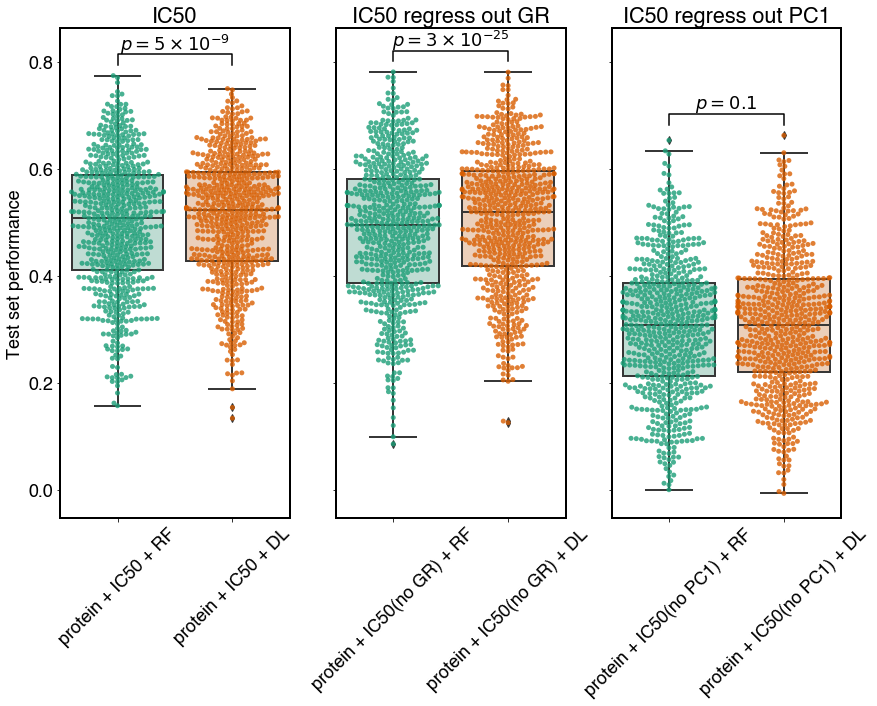

In [115]:
fig, ax = plt.subplots(1, 3, figsize=(14, 10), sharey=True)
ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_protein_ori,
            orient='v',
            linewidth=2,
            ax=ax[0])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_protein_ori,
              orient='vh',
              alpha=.8,
              ax=ax[0])

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_protein_ori['test_corr'].max() + 0.02, 0.02, 'k'
ax[0].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[0].text((x1 + x2) * .5,
           y + w + 0.02,
           r"$p=5\times10^{-9}$",
           ha='center',
           va='center',
           color=col)

ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_protein_growth_corrected,
            orient='v',
            linewidth=2,
            ax=ax[1])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_protein_growth_corrected,
              orient='vh',
              alpha=.8,
              ax=ax[1])

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_protein_growth_corrected['test_corr'].max() + 0.02, 0.02, 'k'
ax[1].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[1].text((x1 + x2) * .5,
           y + w + 0.02,
           r"$p=3\times10^{-25}$",
           ha='center',
           va='center',
           color=col)
# y = test_corr_df_rf[
#     test_corr_df_rf['key'] ==
#     'protein + DL']['test_corr'].median()
# ax[1].plot((-0.5,2.5), [y, y], color='red', zorder=10)

ga = sns.boxplot('key',
            'test_corr',
            data=test_corr_protein_pc1_corrected,
            orient='v',
            linewidth=2,
            ax=ax[2])
for patch in ga.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))
    
sns.swarmplot('key',
              'test_corr',
              data=test_corr_protein_pc1_corrected,
              orient='vh',
              alpha=.8,
              ax=ax[2])

x1, x2 = 0, 1  # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
y, w, col = test_corr_protein_pc1_corrected['test_corr'].max() + 0.02, 0.02, 'k'
ax[2].plot([x1, x1, x2, x2], [y, y + w, y + w, y], lw=1.5, c=col)
ax[2].text((x1 + x2) * .5,
           y + w + 0.02,
           r"$p=0.1$",
           ha='center',
           va='center',
           color=col)

ax[0].set_ylabel('Test set performance')
ax[0].set_xlabel('')
ax[0].set_title('IC50')
ax[1].set_ylabel('')
ax[1].set_xlabel('')
ax[1].set_title('IC50 regress out GR')
ax[2].set_ylabel('')
ax[2].set_xlabel('')
ax[2].set_title('IC50 regress out PC1')
fig.autofmt_xdate(rotation=45, ha='center')

In [114]:
print(ttest_rel(test_corr_protein_ori[test_corr_protein_ori['key']=='protein + IC50 + RF']['test_corr'].values,
          test_corr_protein_ori[test_corr_protein_ori['key']=='protein + IC50 + DL']['test_corr'].values))

print(ttest_rel(
    test_corr_protein_growth_corrected[test_corr_protein_growth_corrected['key'] ==
                                   'protein + IC50(no GR) + RF']['test_corr'].values,
    test_corr_protein_growth_corrected[test_corr_protein_growth_corrected['key'] ==
                                   'protein + IC50(no GR) + DL']['test_corr'].values))

print(ttest_rel(
    test_corr_protein_pc1_corrected[test_corr_protein_pc1_corrected['key'] ==
                                'protein + IC50(no PC1) + RF']['test_corr'].values,
    test_corr_protein_pc1_corrected[test_corr_protein_pc1_corrected['key'] ==
                                'protein + IC50(no PC1) + DL']['test_corr'].values))

Ttest_relResult(statistic=-5.911006859041587, pvalue=5.490797543997486e-09)
Ttest_relResult(statistic=-10.824781675435387, pvalue=3.204106226359657e-25)
Ttest_relResult(statistic=-1.6106562305333014, pvalue=0.1077401422242977)
